# Comprehensive Chess Performance Analysis
## Lichess Games Analysis - Combined Accounts (IsmatS & Cassiny)

This notebook analyzes chess games from both accounts to identify strengths, weaknesses, and improvement opportunities.

In [1]:
# Import required libraries
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for attractive visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Color palette
COLORS = {
    'win': '#2ecc71',
    'loss': '#e74c3c', 
    'draw': '#95a5a6',
    'primary': '#3498db',
    'secondary': '#9b59b6',
    'accent': '#f39c12'
}

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Define your account names
MY_ACCOUNTS = ['IsmatS', 'Cassiny']

def parse_pgn_file(filename):
    """Parse a PGN file and extract comprehensive game data"""
    games_data = []
    
    # Helper function to safely convert to int
    def safe_int(value, default=0):
        try:
            return int(value) if value and value != '?' else default
        except (ValueError, TypeError):
            return default
    
    with open(filename, 'r') as pgn_file:
        game_count = 0
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            
            headers = game.headers
            
            # Extract comprehensive game data
            game_info = {
                'event': headers.get('Event', ''),
                'site': headers.get('Site', ''),
                'date': headers.get('Date', ''),
                'utc_date': headers.get('UTCDate', ''),
                'utc_time': headers.get('UTCTime', ''),
                'white': headers.get('White', ''),
                'black': headers.get('Black', ''),
                'result': headers.get('Result', ''),
                'white_elo': safe_int(headers.get('WhiteElo', 0)),
                'black_elo': safe_int(headers.get('BlackElo', 0)),
                'white_rating_diff': safe_int(headers.get('WhiteRatingDiff', 0)),
                'black_rating_diff': safe_int(headers.get('BlackRatingDiff', 0)),
                'eco': headers.get('ECO', ''),
                'opening': headers.get('Opening', ''),
                'time_control': headers.get('TimeControl', ''),
                'termination': headers.get('Termination', ''),
                'game_id': headers.get('GameId', '')
            }
            
            # Count moves
            moves = 0
            node = game
            while node.variations:
                moves += 1
                node = node.variation(0)
            game_info['total_moves'] = moves
            
            games_data.append(game_info)
            game_count += 1
    
    print(f"  Parsed {game_count} games from {filename}")
    return pd.DataFrame(games_data)

# Parse both PGN files
print("Parsing PGN files...")
df_ismat = parse_pgn_file('data/lichess_IsmatS_2025-12-15.pgn')
df_cassiny = parse_pgn_file('data/lichess_Cassiny_2025-12-15.pgn')

# Combine dataframes
df_all = pd.concat([df_ismat, df_cassiny], ignore_index=True)

print(f"\n✓ Total games loaded: {len(df_all)}")
print(f"  - IsmatS games: {len(df_ismat)}")
print(f"  - Cassiny games: {len(df_cassiny)}")

Parsing PGN files...


  Parsed 1724 games from data/lichess_IsmatS_2025-12-15.pgn


  Parsed 12993 games from data/lichess_Cassiny_2025-12-15.pgn

✓ Total games loaded: 14717
  - IsmatS games: 1724
  - Cassiny games: 12993


In [3]:
# Identify games between the two accounts
games_between_accounts = df_all[
    ((df_all['white'].isin(MY_ACCOUNTS)) & (df_all['black'].isin(MY_ACCOUNTS)))
]

print(f"Games between your two accounts: {len(games_between_accounts)}")
if len(games_between_accounts) > 0:
    print("\nThese games will be counted as draws for overall statistics to avoid bias.")
    print(games_between_accounts[['date', 'white', 'black', 'result', 'opening']].to_string())

Games between your two accounts: 134

These games will be counted as draws for overall statistics to avoid bias.
             date    white    black   result                                                               opening
1091   2023.08.19  Cassiny   IsmatS      1-0                                                      Philidor Defense
1092   2022.12.07   IsmatS  Cassiny      0-1                                                        Mieses Opening
1094   2022.09.25  Cassiny   IsmatS  1/2-1/2                                                     Hungarian Opening
1095   2022.09.25   IsmatS  Cassiny      0-1                                            Owen Defense: Smith Gambit
1096   2022.09.25   IsmatS  Cassiny      0-1                                       Petrov's Defense: Modern Attack
1097   2022.07.23  Cassiny   IsmatS      1-0                                                        Modern Defense
1098   2022.07.23   IsmatS  Cassiny      0-1                                      

In [4]:
# Create a unified dataset where we track "my" performance
def process_games(df):
    """Process games to create a unified view from player's perspective"""
    processed_games = []
    
    for _, game in df.iterrows():
        # Determine if this is a game between my two accounts
        is_self_game = game['white'] in MY_ACCOUNTS and game['black'] in MY_ACCOUNTS
        
        # Check if I played as white or black
        if game['white'] in MY_ACCOUNTS:
            my_color = 'white'
            my_account = game['white']
            my_elo = game['white_elo']
            opponent_elo = game['black_elo']
            my_rating_diff = game['white_rating_diff']
            opponent = game['black']
        elif game['black'] in MY_ACCOUNTS:
            my_color = 'black'
            my_account = game['black']
            my_elo = game['black_elo']
            opponent_elo = game['white_elo']
            my_rating_diff = game['black_rating_diff']
            opponent = game['white']
        else:
            continue  # Skip games where neither player is me
        
        # Determine result from my perspective
        if is_self_game:
            my_result = 'draw'  # Treat games between accounts as draws
        elif game['result'] == '1/2-1/2':
            my_result = 'draw'
        elif (my_color == 'white' and game['result'] == '1-0') or \
             (my_color == 'black' and game['result'] == '0-1'):
            my_result = 'win'
        else:
            my_result = 'loss'
        
        # Calculate rating difference (opponent - my rating)
        rating_diff = opponent_elo - my_elo
        
        # Parse time control
        tc = game['time_control']
        if '+' in tc:
            base_time = int(tc.split('+')[0])
        else:
            base_time = int(tc) if tc.isdigit() else 0
        
        # Categorize time control
        if base_time < 180:
            tc_category = 'Bullet'
        elif base_time < 600:
            tc_category = 'Blitz'
        elif base_time < 1500:
            tc_category = 'Rapid'
        else:
            tc_category = 'Classical'
        
        # Parse date
        try:
            date_obj = datetime.strptime(game['date'], '%Y.%m.%d')
            day_of_week = date_obj.strftime('%A')
            month = date_obj.strftime('%Y-%m')
        except:
            day_of_week = 'Unknown'
            month = 'Unknown'
        
        processed_game = {
            'date': game['date'],
            'month': month,
            'day_of_week': day_of_week,
            'my_account': my_account,
            'my_color': my_color,
            'my_elo': my_elo,
            'opponent': opponent,
            'opponent_elo': opponent_elo,
            'rating_diff': rating_diff,
            'my_rating_change': my_rating_diff,
            'result': my_result,
            'eco': game['eco'],
            'opening': game['opening'],
            'time_control': game['time_control'],
            'tc_category': tc_category,
            'termination': game['termination'],
            'total_moves': game['total_moves'],
            'is_self_game': is_self_game,
            'game_id': game['game_id']
        }
        
        processed_games.append(processed_game)
    
    return pd.DataFrame(processed_games)

# Process the data
df = process_games(df_all)

print(f"✓ Processed {len(df)} games")
print(f"\nResult distribution:")
print(df['result'].value_counts())
print(f"\nSelf-games: {df['is_self_game'].sum()}")

✓ Processed 14717 games

Result distribution:
result
win     7143
loss    6921
draw     653
Name: count, dtype: int64

Self-games: 134


In [5]:
# Quick overview statistics
print("=" * 80)
print("OVERALL STATISTICS")
print("=" * 80)
print(f"\nTotal Games: {len(df)}")
print(f"Wins: {(df['result'] == 'win').sum()} ({(df['result'] == 'win').sum()/len(df)*100:.1f}%)")
print(f"Losses: {(df['result'] == 'loss').sum()} ({(df['result'] == 'loss').sum()/len(df)*100:.1f}%)")
print(f"Draws: {(df['result'] == 'draw').sum()} ({(df['result'] == 'draw').sum()/len(df)*100:.1f}%)")

print(f"\nAverage Rating: {df['my_elo'].mean():.0f}")
print(f"Rating Range: {df['my_elo'].min()} - {df['my_elo'].max()}")
print(f"Total Rating Gained: {df['my_rating_change'].sum():+d}")

print(f"\nGames as White: {(df['my_color'] == 'white').sum()} ({(df['my_color'] == 'white').sum()/len(df)*100:.1f}%)")
print(f"Games as Black: {(df['my_color'] == 'black').sum()} ({(df['my_color'] == 'black').sum()/len(df)*100:.1f}%)")

print(f"\nAverage Game Length: {df['total_moves'].mean():.1f} moves")
print(f"Shortest Game: {df['total_moves'].min()} moves")
print(f"Longest Game: {df['total_moves'].max()} moves")

OVERALL STATISTICS

Total Games: 14717
Wins: 7143 (48.5%)
Losses: 6921 (47.0%)
Draws: 653 (4.4%)

Average Rating: 1587
Rating Range: 1074 - 1991
Total Rating Gained: +374

Games as White: 7422 (50.4%)
Games as Black: 7295 (49.6%)

Average Game Length: 64.4 moves
Shortest Game: 2 moves
Longest Game: 244 moves


---
## Chart Generation
### Creating 20 Meaningful Charts for Performance Analysis

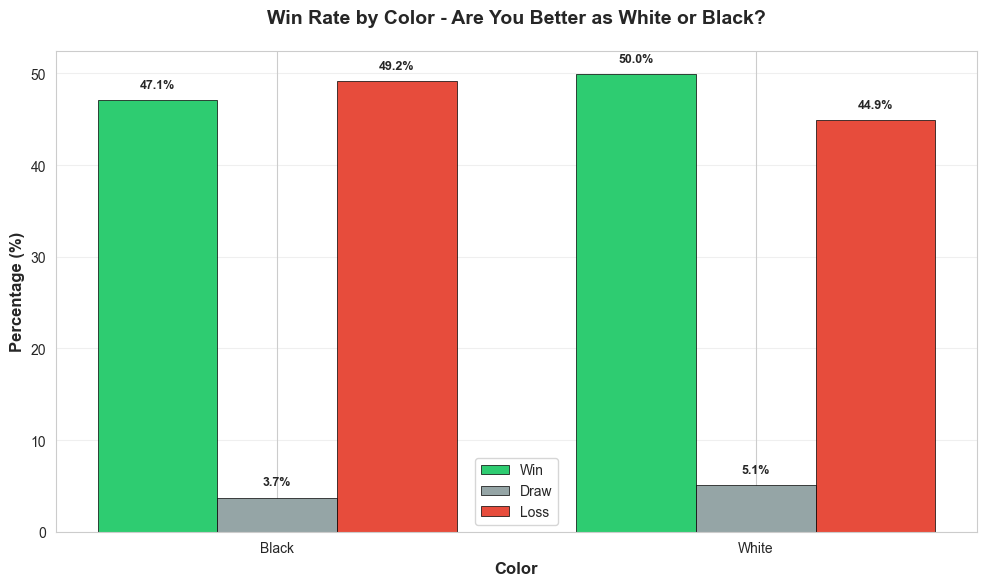

✓ Chart 1 saved: Win Rate by Color


In [6]:
# Chart 1: Win Rate by Color
fig, ax = plt.subplots(figsize=(10, 6))

color_stats = df.groupby('my_color')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
color_stats = color_stats[['win', 'draw', 'loss']]

x = np.arange(len(color_stats.index))
width = 0.25

ax.bar(x - width, color_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, color_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, color_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Color', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Win Rate by Color - Are You Better as White or Black?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Black', 'White'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, color in enumerate(['win', 'draw', 'loss']):
    for j, val in enumerate(color_stats[color]):
        offset = width * (i - 1)
        ax.text(j + offset, val + 1, f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('charts/01_win_rate_by_color.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 1 saved: Win Rate by Color")

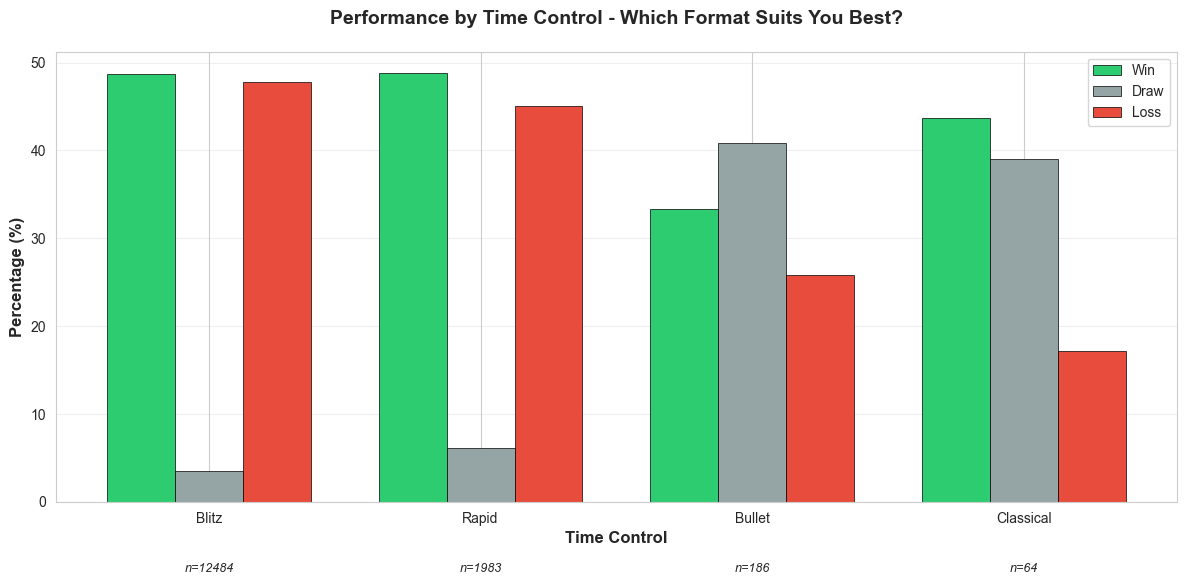

✓ Chart 2 saved: Performance by Time Control


In [7]:
# Chart 2: Performance by Time Control
fig, ax = plt.subplots(figsize=(12, 6))

tc_stats = df.groupby('tc_category')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
tc_stats = tc_stats[['win', 'draw', 'loss']]

# Sort by total games
tc_counts = df['tc_category'].value_counts()
tc_stats = tc_stats.reindex(tc_counts.index)

x = np.arange(len(tc_stats.index))
width = 0.25

ax.bar(x - width, tc_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, tc_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, tc_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Time Control', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Performance by Time Control - Which Format Suits You Best?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(tc_stats.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add game counts
for i, tc in enumerate(tc_stats.index):
    ax.text(i, -8, f'n={tc_counts[tc]}', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('charts/02_performance_by_time_control.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 2 saved: Performance by Time Control")

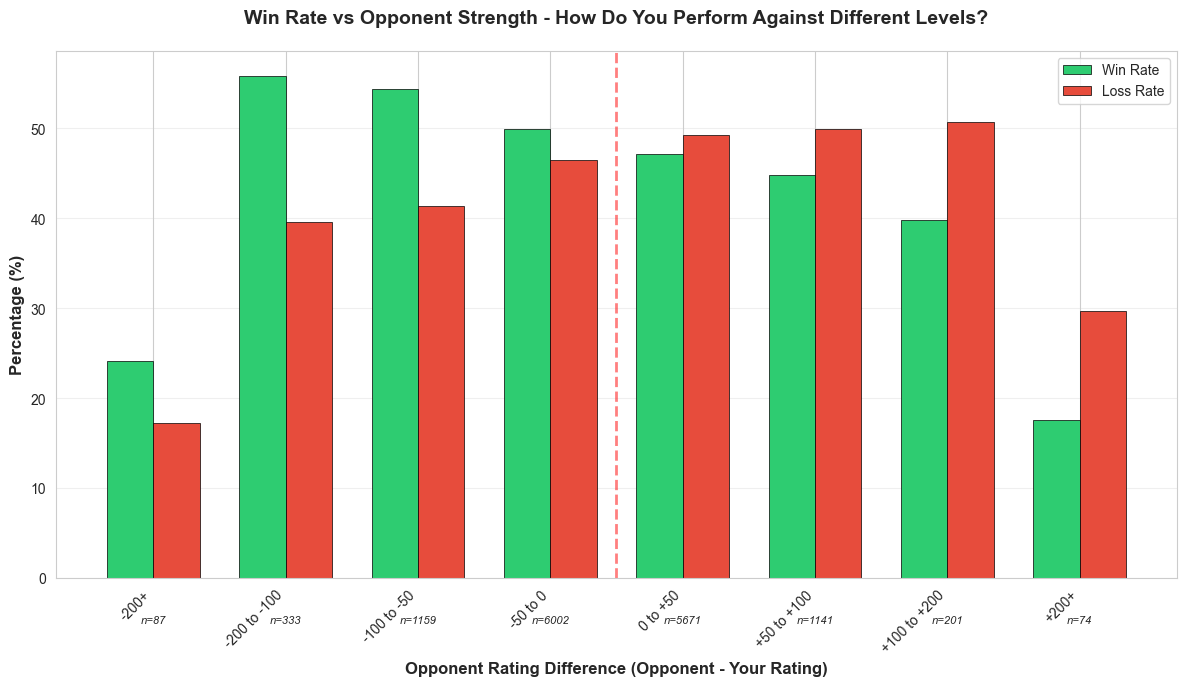

✓ Chart 3 saved: Win Rate vs Opponent Rating Difference


In [8]:
# Chart 3: Win Rate vs Opponent Rating Difference
fig, ax = plt.subplots(figsize=(12, 7))

# Create rating difference bins
bins = [-500, -200, -100, -50, 0, 50, 100, 200, 500]
labels = ['-200+', '-200 to -100', '-100 to -50', '-50 to 0', '0 to +50', '+50 to +100', '+100 to +200', '+200+']
df['rating_diff_bin'] = pd.cut(df['rating_diff'], bins=bins, labels=labels)

rating_stats = df.groupby('rating_diff_bin')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
rating_stats = rating_stats[['win', 'loss']]

x = np.arange(len(rating_stats.index))
width = 0.35

ax.bar(x - width/2, rating_stats['win'], width, label='Win Rate', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x + width/2, rating_stats['loss'], width, label='Loss Rate', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Opponent Rating Difference (Opponent - Your Rating)', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Win Rate vs Opponent Strength - How Do You Perform Against Different Levels?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.axvline(x=3.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Even rating')

# Add game counts
bin_counts = df['rating_diff_bin'].value_counts().sort_index()
for i, (idx, count) in enumerate(bin_counts.items()):
    ax.text(i, -5, f'n={count}', ha='center', fontsize=8, style='italic')

plt.tight_layout()
plt.savefig('charts/03_win_rate_vs_opponent_rating.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 3 saved: Win Rate vs Opponent Rating Difference")

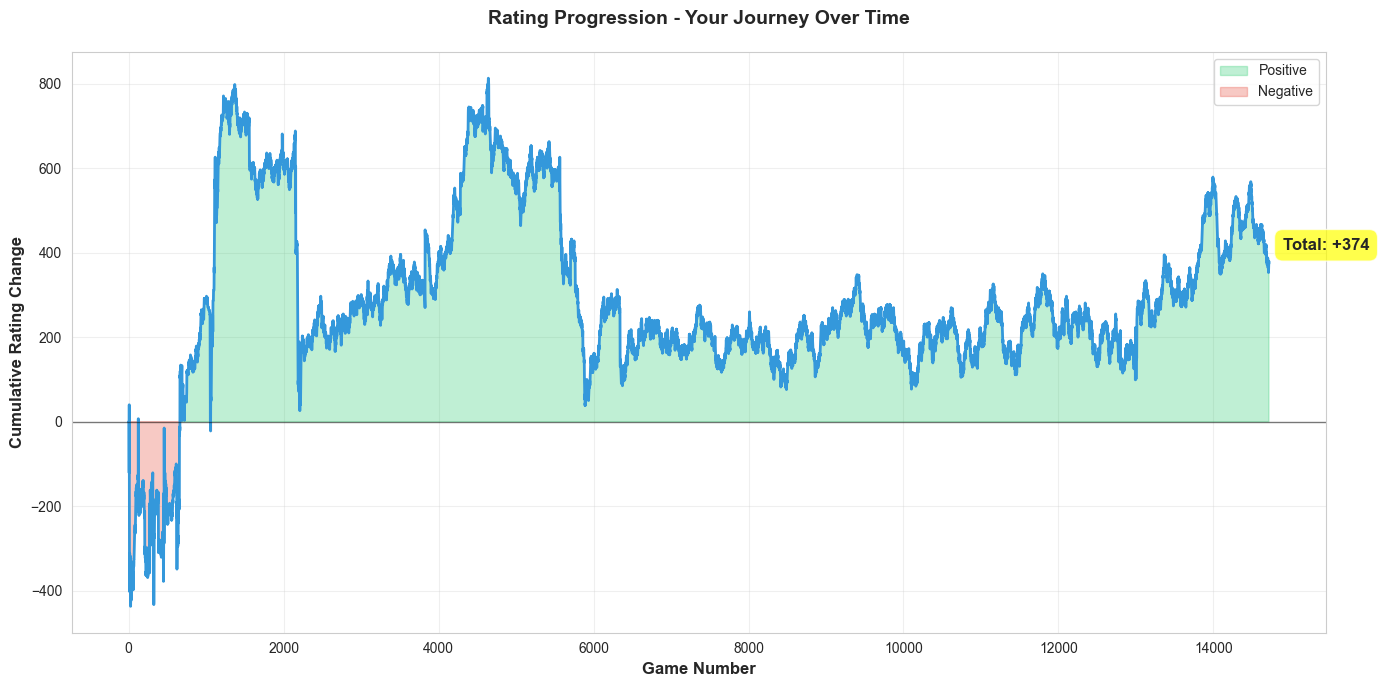

✓ Chart 4 saved: Rating Progression Over Time


In [9]:
# Chart 4: Rating Progression Over Time
fig, ax = plt.subplots(figsize=(14, 7))

# Sort by date
df_sorted = df.sort_values('date').reset_index(drop=True)
df_sorted['cumulative_rating_change'] = df_sorted['my_rating_change'].cumsum()
df_sorted['game_number'] = range(1, len(df_sorted) + 1)

# Plot cumulative rating change
ax.plot(df_sorted['game_number'], df_sorted['cumulative_rating_change'], linewidth=2, color=COLORS['primary'])
ax.fill_between(df_sorted['game_number'], df_sorted['cumulative_rating_change'], 0, 
                where=(df_sorted['cumulative_rating_change'] >= 0), alpha=0.3, color=COLORS['win'], label='Positive')
ax.fill_between(df_sorted['game_number'], df_sorted['cumulative_rating_change'], 0,
                where=(df_sorted['cumulative_rating_change'] < 0), alpha=0.3, color=COLORS['loss'], label='Negative')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('Game Number', fontweight='bold')
ax.set_ylabel('Cumulative Rating Change', fontweight='bold')
ax.set_title('Rating Progression - Your Journey Over Time', fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend()

# Add final value annotation
final_change = df_sorted['cumulative_rating_change'].iloc[-1]
ax.annotate(f'Total: {final_change:+.0f}', 
            xy=(len(df_sorted), final_change), 
            xytext=(10, 10), textcoords='offset points',
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('charts/04_rating_progression.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 4 saved: Rating Progression Over Time")

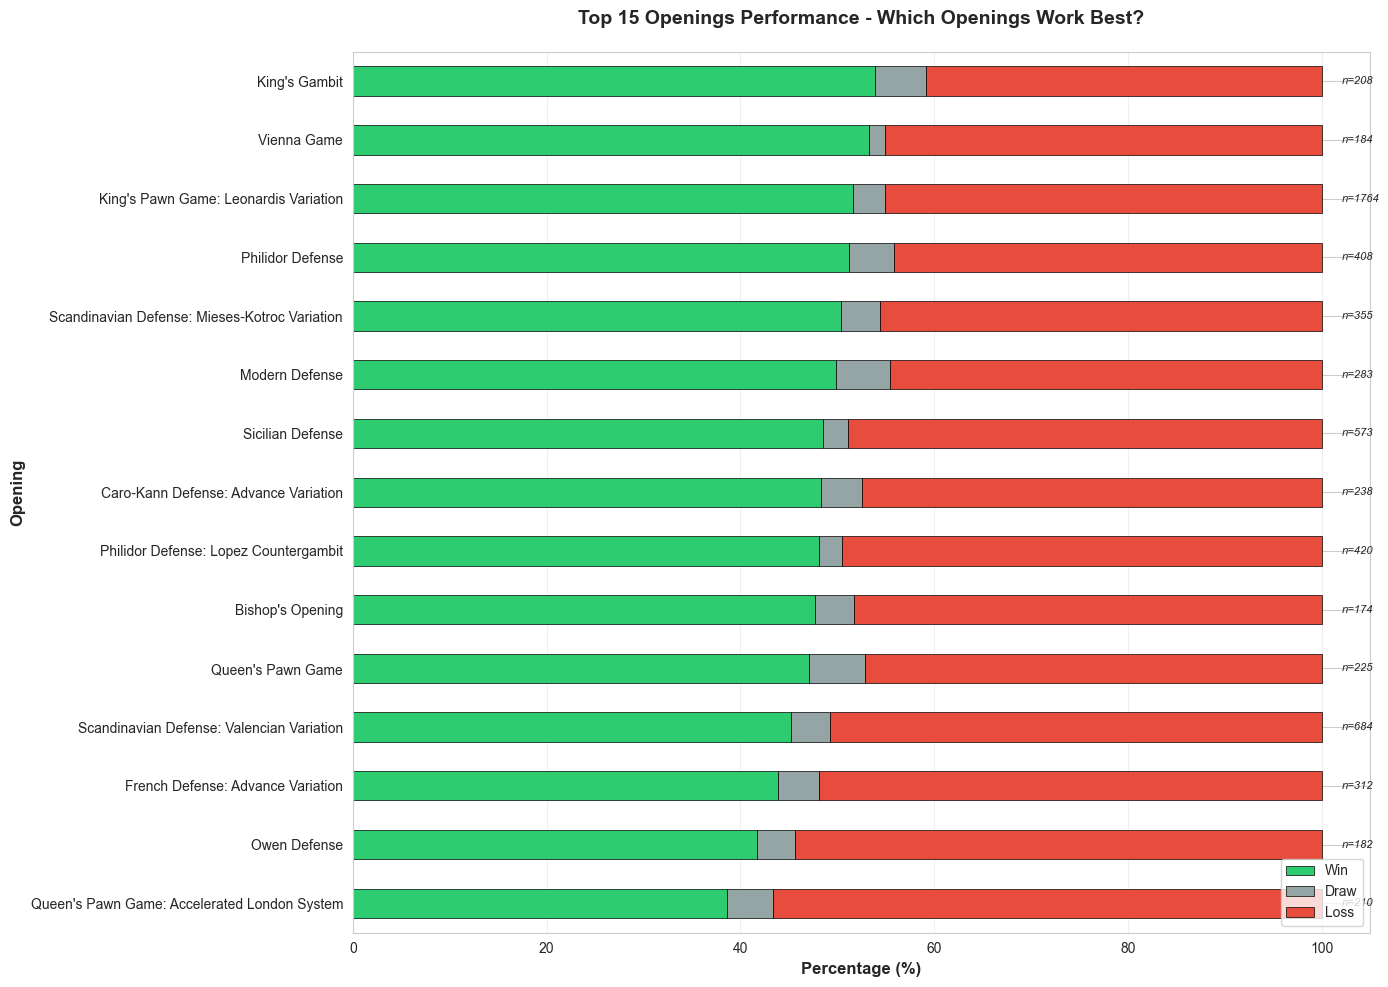

✓ Chart 5 saved: Top 15 Openings Performance


In [10]:
# Chart 5: Top 15 Openings Performance
fig, ax = plt.subplots(figsize=(14, 10))

# Get top 15 openings by frequency
top_openings = df['opening'].value_counts().head(15).index
df_top_openings = df[df['opening'].isin(top_openings)]

opening_stats = df_top_openings.groupby('opening')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
opening_stats = opening_stats[['win', 'draw', 'loss']]

# Sort by win rate
opening_stats = opening_stats.sort_values('win', ascending=True)

# Create horizontal stacked bar chart
opening_stats.plot(kind='barh', stacked=True, ax=ax, 
                   color=[COLORS['win'], COLORS['draw'], COLORS['loss']],
                   edgecolor='black', linewidth=0.5)

ax.set_xlabel('Percentage (%)', fontweight='bold')
ax.set_ylabel('Opening', fontweight='bold')
ax.set_title('Top 15 Openings Performance - Which Openings Work Best?', fontweight='bold', pad=20)
ax.legend(['Win', 'Draw', 'Loss'], loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Add game counts
opening_counts = df_top_openings['opening'].value_counts()
for i, opening in enumerate(opening_stats.index):
    ax.text(102, i, f'n={opening_counts[opening]}', va='center', fontsize=8, style='italic')

plt.tight_layout()
plt.savefig('charts/05_top_openings_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 5 saved: Top 15 Openings Performance")

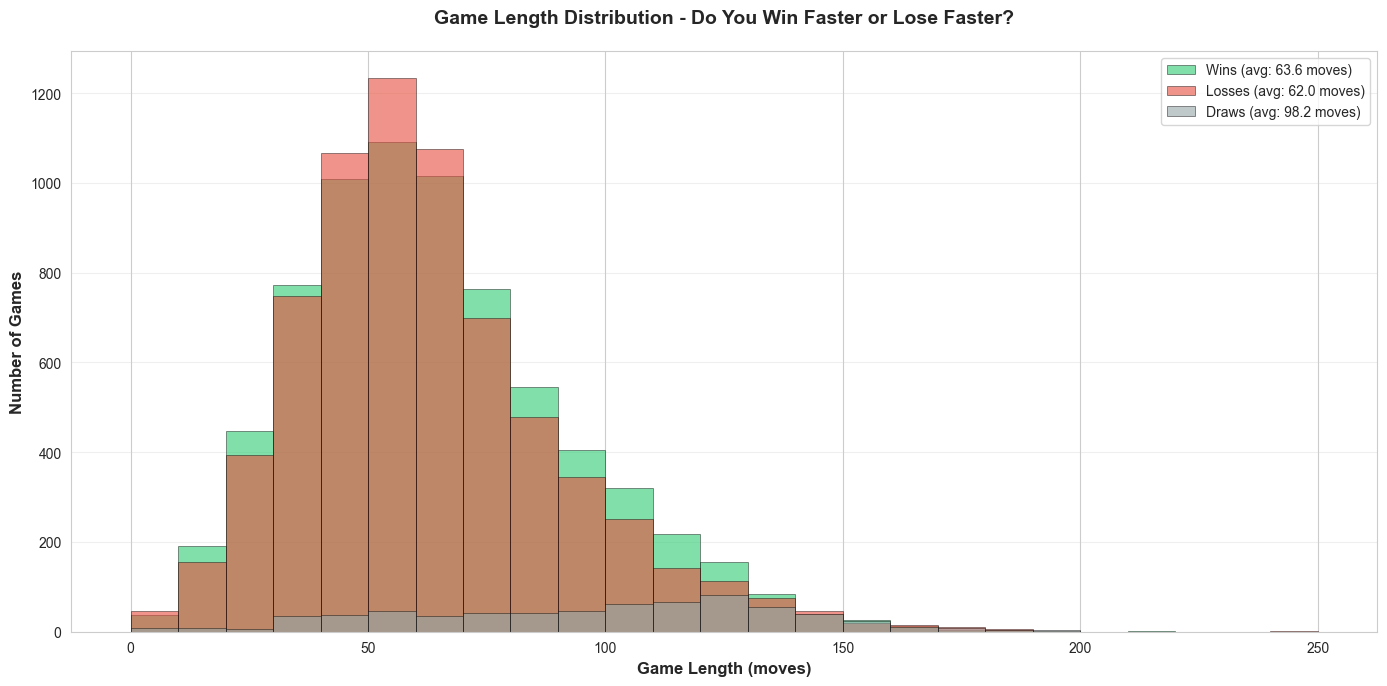

✓ Chart 6 saved: Game Length Distribution by Result


In [11]:
# Chart 6: Game Length Distribution by Result
fig, ax = plt.subplots(figsize=(14, 7))

# Create separate distributions for wins, losses, and draws
wins = df[df['result'] == 'win']['total_moves']
losses = df[df['result'] == 'loss']['total_moves']
draws = df[df['result'] == 'draw']['total_moves']

# Plot distributions
bins = range(0, df['total_moves'].max() + 10, 10)
ax.hist(wins, bins=bins, alpha=0.6, label=f'Wins (avg: {wins.mean():.1f} moves)', 
        color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.hist(losses, bins=bins, alpha=0.6, label=f'Losses (avg: {losses.mean():.1f} moves)', 
        color=COLORS['loss'], edgecolor='black', linewidth=0.5)
if len(draws) > 0:
    ax.hist(draws, bins=bins, alpha=0.6, label=f'Draws (avg: {draws.mean():.1f} moves)', 
            color=COLORS['draw'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Game Length (moves)', fontweight='bold')
ax.set_ylabel('Number of Games', fontweight='bold')
ax.set_title('Game Length Distribution - Do You Win Faster or Lose Faster?', fontweight='bold', pad=20)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('charts/06_game_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 6 saved: Game Length Distribution by Result")

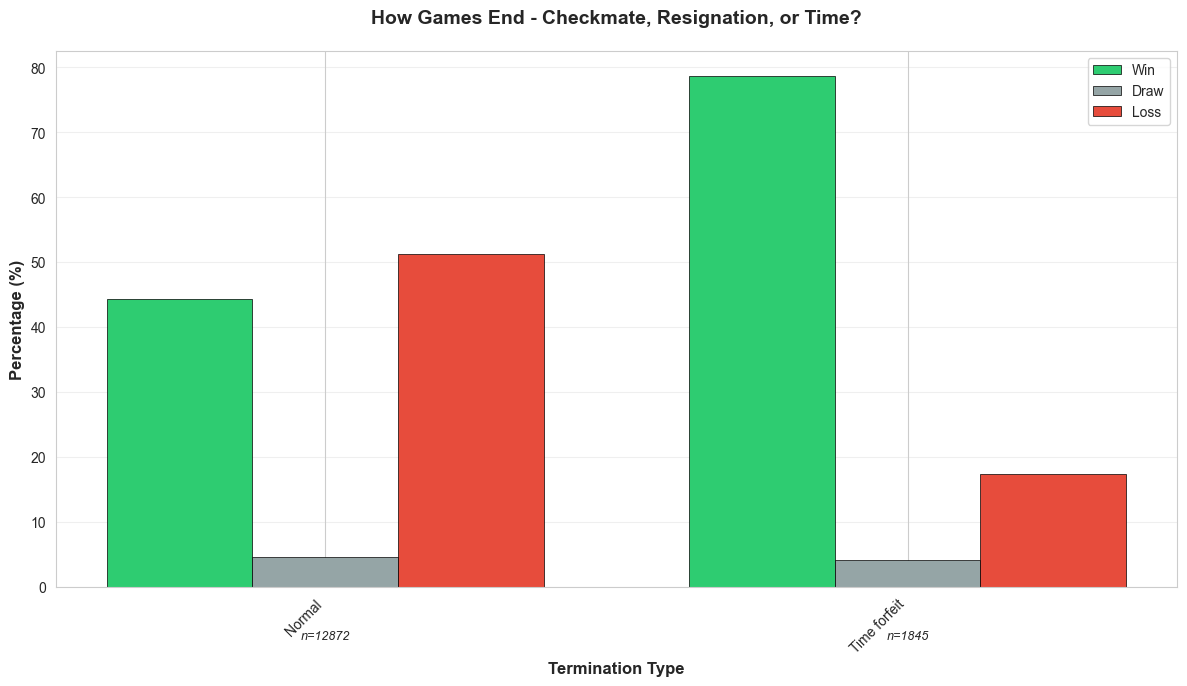

✓ Chart 7 saved: Termination Type Analysis


In [12]:
# Chart 7: Termination Type Analysis
fig, ax = plt.subplots(figsize=(12, 7))

term_stats = df.groupby('termination')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
term_stats = term_stats[['win', 'draw', 'loss']]

# Sort by total games
term_counts = df['termination'].value_counts()
term_stats = term_stats.reindex(term_counts.index)

x = np.arange(len(term_stats.index))
width = 0.25

ax.bar(x - width, term_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, term_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, term_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Termination Type', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('How Games End - Checkmate, Resignation, or Time?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(term_stats.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add game counts
for i, term in enumerate(term_stats.index):
    ax.text(i, -8, f'n={term_counts[term]}', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('charts/07_termination_type_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 7 saved: Termination Type Analysis")

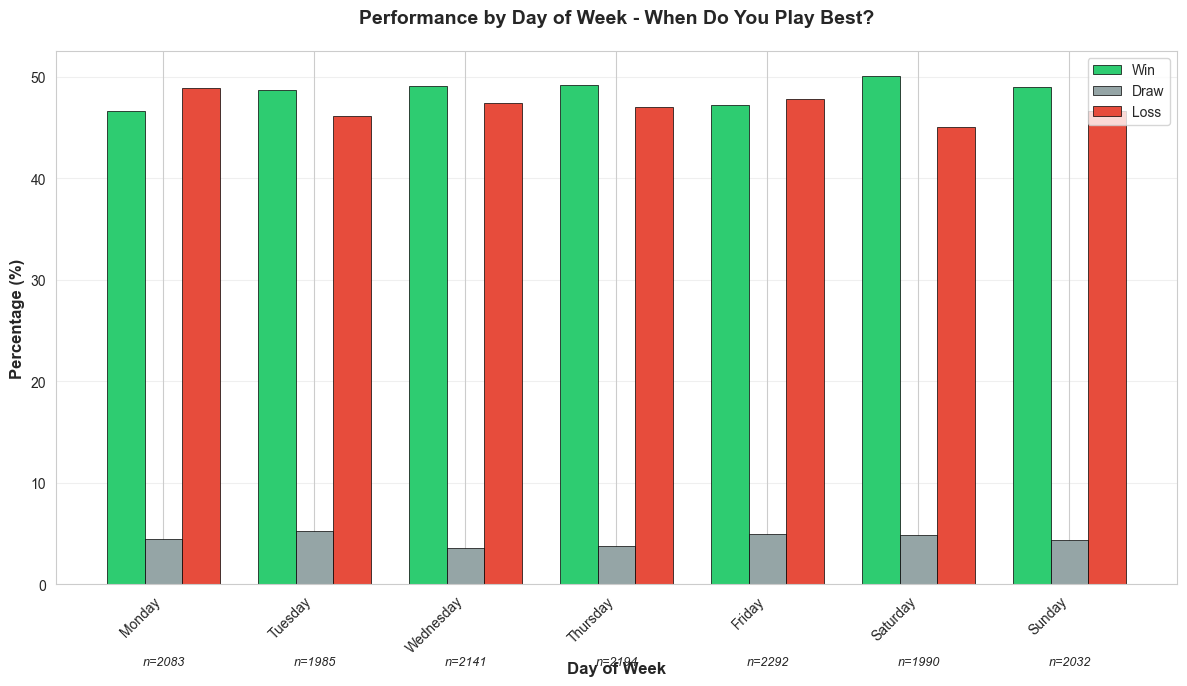

✓ Chart 8 saved: Performance by Day of Week


In [13]:
# Chart 8: Performance by Day of Week
fig, ax = plt.subplots(figsize=(12, 7))

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

day_stats = df.groupby('day_of_week')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
day_stats = day_stats[['win', 'draw', 'loss']]

x = np.arange(len(day_stats.index))
width = 0.25

ax.bar(x - width, day_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, day_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, day_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Day of Week', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Performance by Day of Week - When Do You Play Best?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(day_stats.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add game counts
day_counts = df['day_of_week'].value_counts().reindex(days_order, fill_value=0)
for i, day in enumerate(day_stats.index):
    ax.text(i, -8, f'n={day_counts[day]}', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('charts/08_performance_by_day_of_week.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 8 saved: Performance by Day of Week")

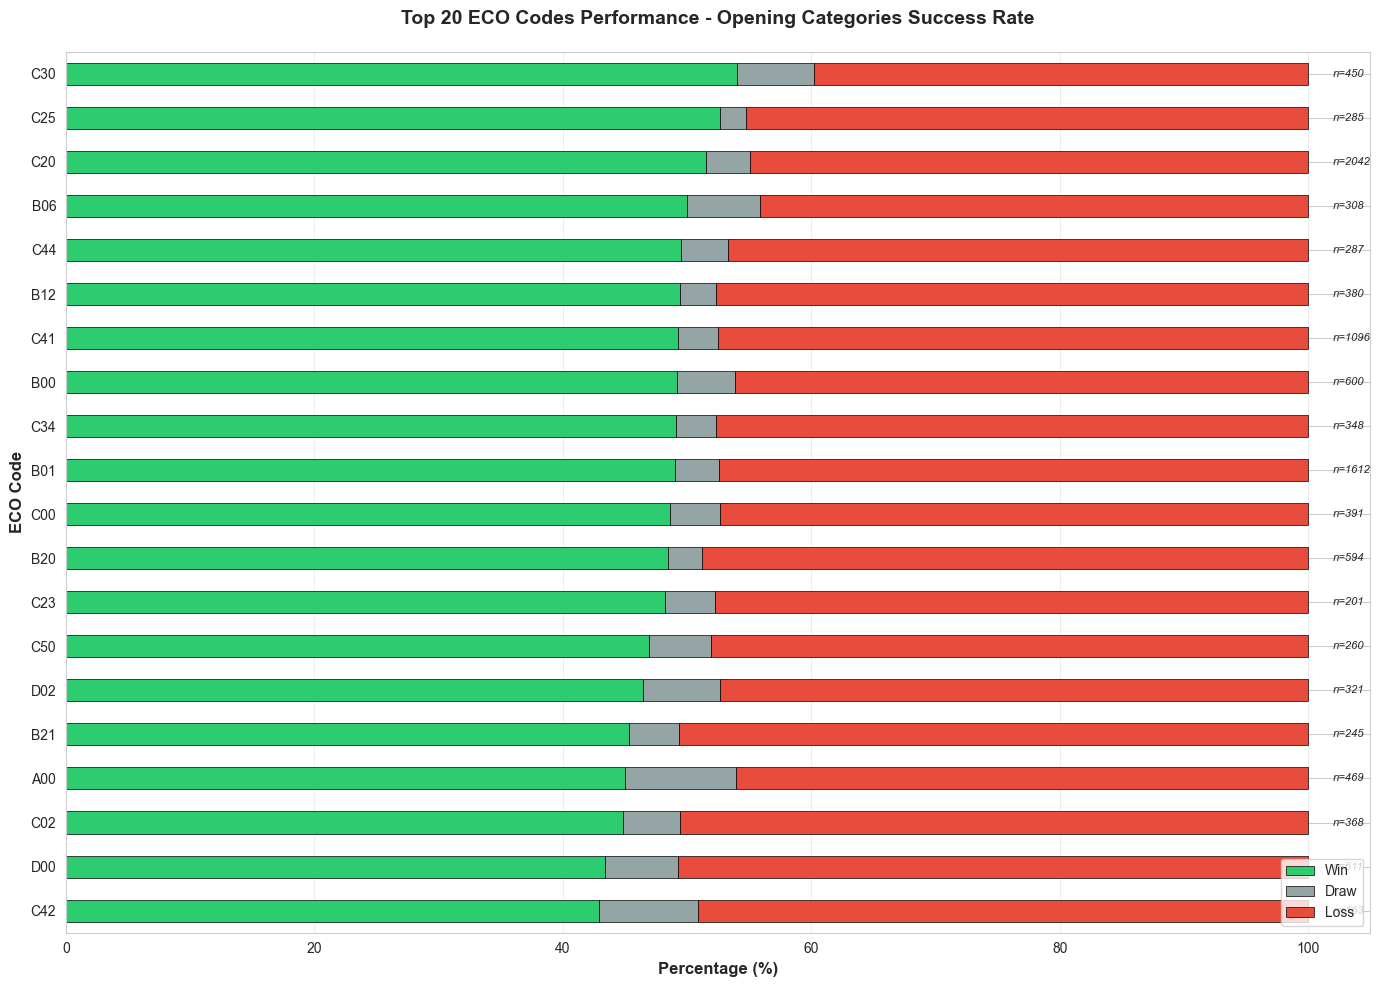

✓ Chart 9 saved: ECO Code Performance


In [14]:
# Chart 9: ECO Code Performance (Top 20)
fig, ax = plt.subplots(figsize=(14, 10))

# Get top 20 ECO codes by frequency
top_eco = df['eco'].value_counts().head(20).index
df_top_eco = df[df['eco'].isin(top_eco)]

eco_stats = df_top_eco.groupby('eco')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
eco_stats = eco_stats[['win', 'draw', 'loss']]

# Sort by win rate
eco_stats = eco_stats.sort_values('win', ascending=True)

# Create horizontal stacked bar chart
eco_stats.plot(kind='barh', stacked=True, ax=ax,
               color=[COLORS['win'], COLORS['draw'], COLORS['loss']],
               edgecolor='black', linewidth=0.5)

ax.set_xlabel('Percentage (%)', fontweight='bold')
ax.set_ylabel('ECO Code', fontweight='bold')
ax.set_title('Top 20 ECO Codes Performance - Opening Categories Success Rate', fontweight='bold', pad=20)
ax.legend(['Win', 'Draw', 'Loss'], loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Add game counts
eco_counts = df_top_eco['eco'].value_counts()
for i, eco in enumerate(eco_stats.index):
    ax.text(102, i, f'n={eco_counts[eco]}', va='center', fontsize=8, style='italic')

plt.tight_layout()
plt.savefig('charts/09_eco_code_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 9 saved: ECO Code Performance")

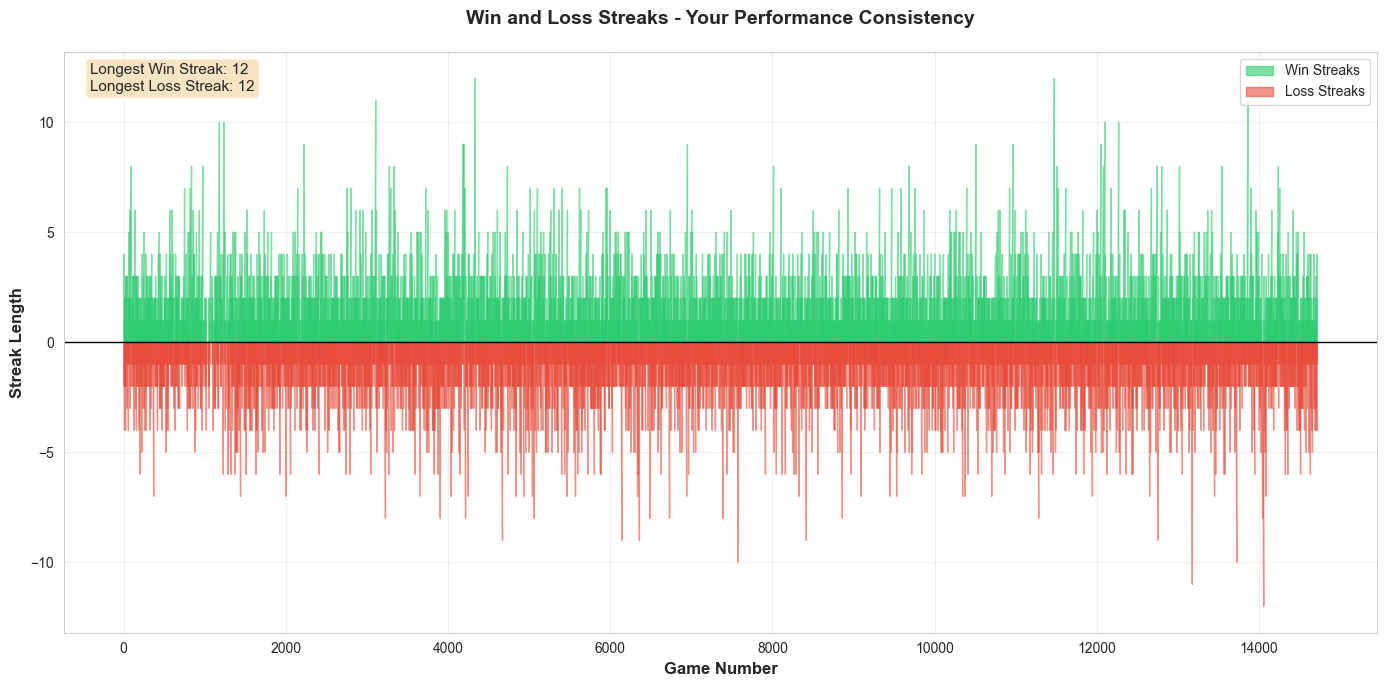

✓ Chart 10 saved: Win and Loss Streaks


In [15]:
# Chart 10: Win Streaks Analysis
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate streaks
df_sorted = df.sort_values('date').reset_index(drop=True)
df_sorted['is_win'] = (df_sorted['result'] == 'win').astype(int)
df_sorted['is_loss'] = (df_sorted['result'] == 'loss').astype(int)

# Find win streaks
df_sorted['win_streak'] = df_sorted['is_win'] * (df_sorted['is_win'].groupby((df_sorted['is_win'] != df_sorted['is_win'].shift()).cumsum()).cumsum())
# Find loss streaks  
df_sorted['loss_streak'] = df_sorted['is_loss'] * (df_sorted['is_loss'].groupby((df_sorted['is_loss'] != df_sorted['is_loss'].shift()).cumsum()).cumsum())

# Plot streaks over time
df_sorted['game_number'] = range(1, len(df_sorted) + 1)

ax.fill_between(df_sorted['game_number'], df_sorted['win_streak'], 0, 
                where=(df_sorted['win_streak'] > 0), alpha=0.6, color=COLORS['win'], label='Win Streaks')
ax.fill_between(df_sorted['game_number'], -df_sorted['loss_streak'], 0,
                where=(df_sorted['loss_streak'] > 0), alpha=0.6, color=COLORS['loss'], label='Loss Streaks')

ax.set_xlabel('Game Number', fontweight='bold')
ax.set_ylabel('Streak Length', fontweight='bold')
ax.set_title('Win and Loss Streaks - Your Performance Consistency', fontweight='bold', pad=20)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.legend()
ax.grid(True, alpha=0.3)

# Add annotations for max streaks
max_win_streak = df_sorted['win_streak'].max()
max_loss_streak = df_sorted['loss_streak'].max()
ax.text(0.02, 0.98, f'Longest Win Streak: {max_win_streak}\nLongest Loss Streak: {max_loss_streak}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('charts/10_win_loss_streaks.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 10 saved: Win and Loss Streaks")

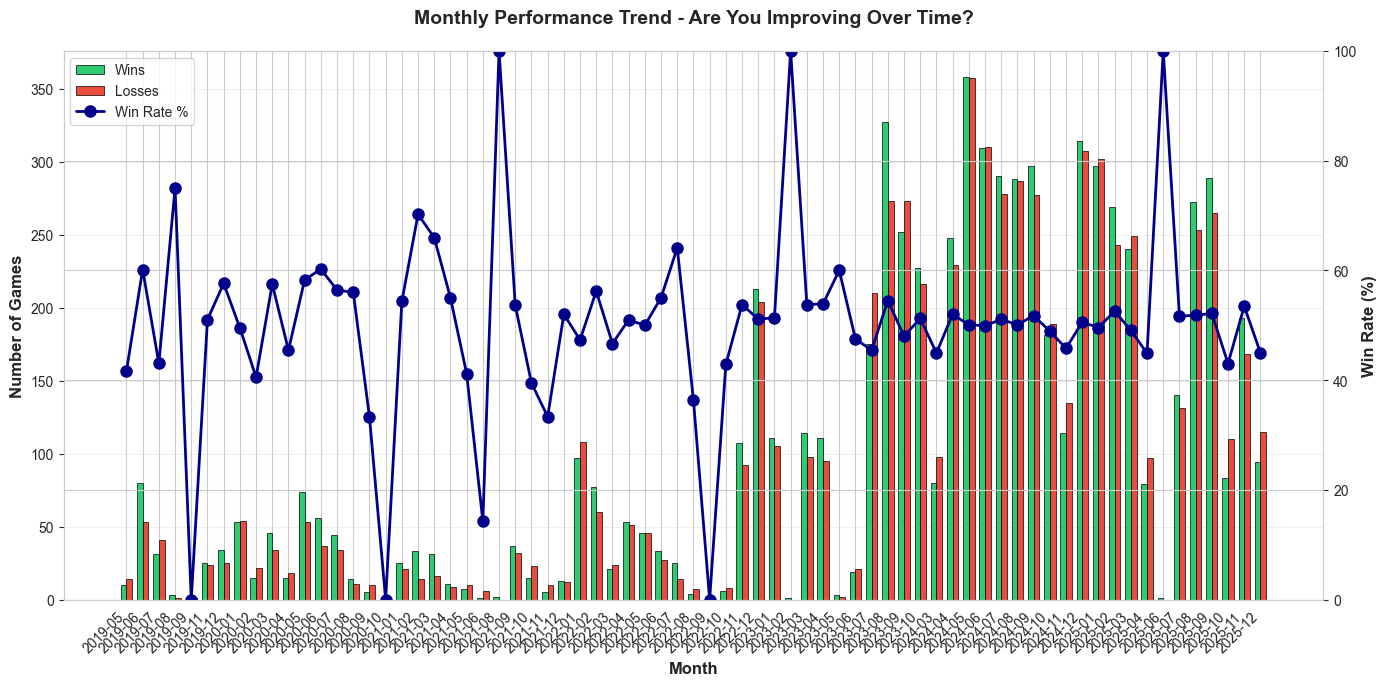

✓ Chart 11 saved: Monthly Performance Trend


In [16]:
# Chart 11: Monthly Performance Trend
fig, ax = plt.subplots(figsize=(14, 7))

# Group by month
monthly_results = df.groupby(['month', 'result']).size().unstack(fill_value=0)
monthly_results = monthly_results[['win', 'loss']]
monthly_results = monthly_results.sort_index()

# Calculate win rate
monthly_results['total'] = monthly_results.sum(axis=1)
monthly_results['win_rate'] = (monthly_results['win'] / monthly_results['total']) * 100

# Create bar chart with line overlay
x = np.arange(len(monthly_results.index))
width = 0.35

ax.bar(x - width/2, monthly_results['win'], width, label='Wins', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x + width/2, monthly_results['loss'], width, label='Losses', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

# Add win rate line on secondary axis
ax2 = ax.twinx()
ax2.plot(x, monthly_results['win_rate'], color='darkblue', marker='o', linewidth=2, markersize=8, label='Win Rate %')
ax2.set_ylabel('Win Rate (%)', fontweight='bold')
ax2.set_ylim(0, 100)

ax.set_xlabel('Month', fontweight='bold')
ax.set_ylabel('Number of Games', fontweight='bold')
ax.set_title('Monthly Performance Trend - Are You Improving Over Time?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(monthly_results.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('charts/11_monthly_performance_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 11 saved: Monthly Performance Trend")

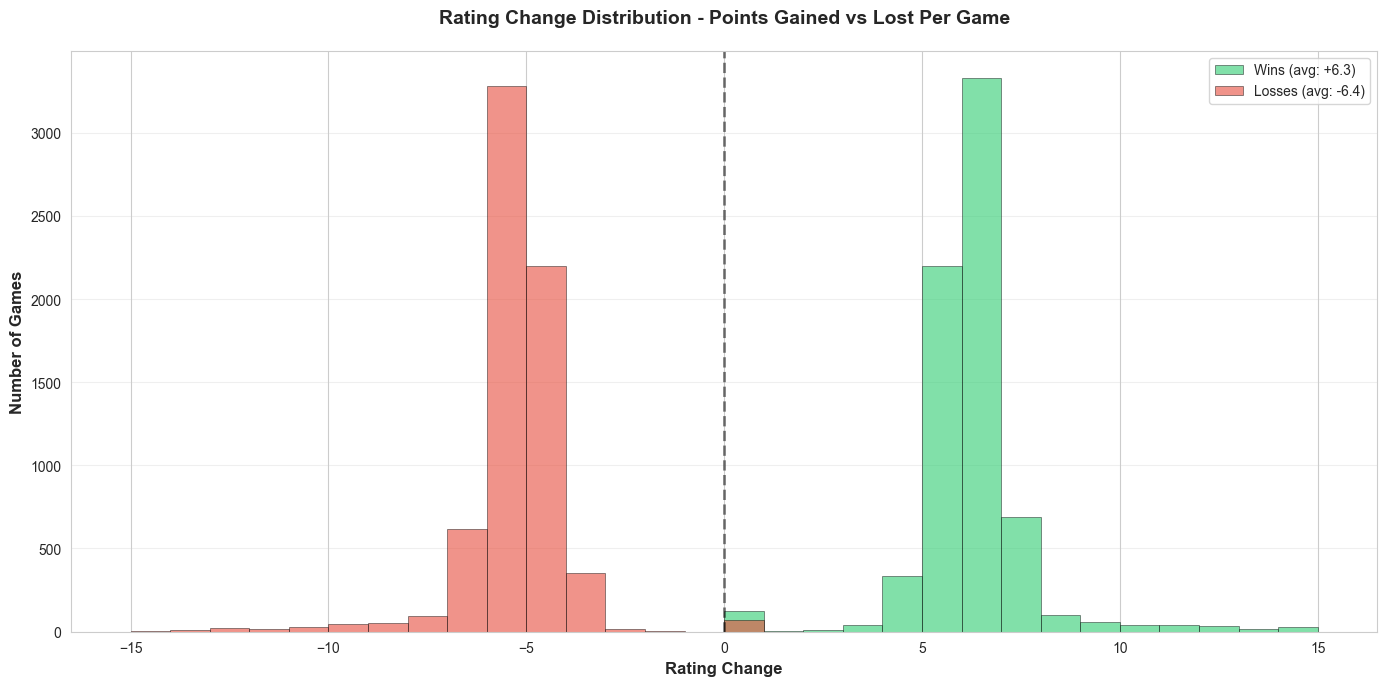

✓ Chart 12 saved: Rating Change Distribution


In [17]:
# Chart 12: Rating Change Distribution
fig, ax = plt.subplots(figsize=(14, 7))

# Separate rating changes by result
win_changes = df[df['result'] == 'win']['my_rating_change']
loss_changes = df[df['result'] == 'loss']['my_rating_change']

# Create histograms
bins = range(-15, 16, 1)
ax.hist(win_changes, bins=bins, alpha=0.6, label=f'Wins (avg: {win_changes.mean():+.1f})', 
        color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.hist(loss_changes, bins=bins, alpha=0.6, label=f'Losses (avg: {loss_changes.mean():+.1f})', 
        color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel('Rating Change', fontweight='bold')
ax.set_ylabel('Number of Games', fontweight='bold')
ax.set_title('Rating Change Distribution - Points Gained vs Lost Per Game', fontweight='bold', pad=20)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('charts/12_rating_change_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 12 saved: Rating Change Distribution")

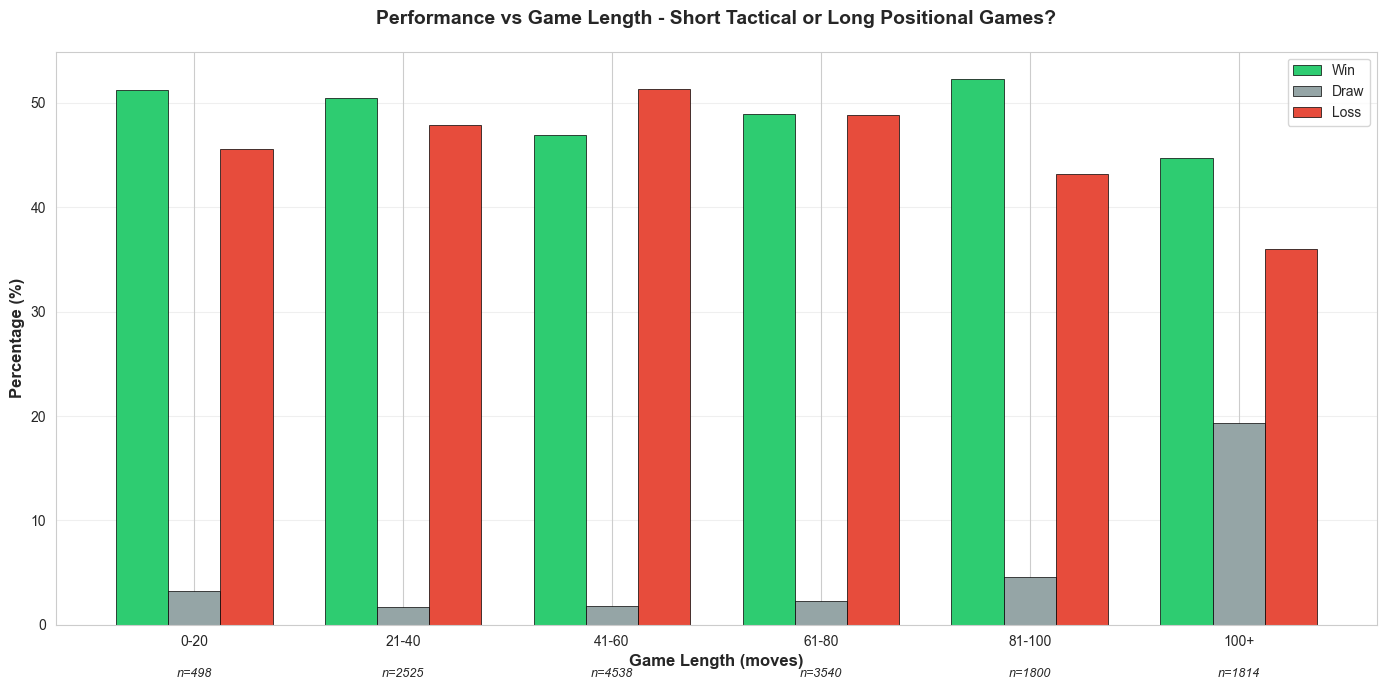

✓ Chart 13 saved: Performance vs Game Length


In [18]:
# Chart 13: Performance vs Game Length
fig, ax = plt.subplots(figsize=(14, 7))

# Create game length bins
bins = [0, 20, 40, 60, 80, 100, 200]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '100+']
df['length_bin'] = pd.cut(df['total_moves'], bins=bins, labels=labels)

length_stats = df.groupby('length_bin')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
length_stats = length_stats[['win', 'draw', 'loss']]

x = np.arange(len(length_stats.index))
width = 0.25

ax.bar(x - width, length_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, length_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, length_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Game Length (moves)', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Performance vs Game Length - Short Tactical or Long Positional Games?', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add game counts
length_counts = df['length_bin'].value_counts().sort_index()
for i, (idx, count) in enumerate(length_counts.items()):
    ax.text(i, -5, f'n={count}', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('charts/13_performance_vs_game_length.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 13 saved: Performance vs Game Length")

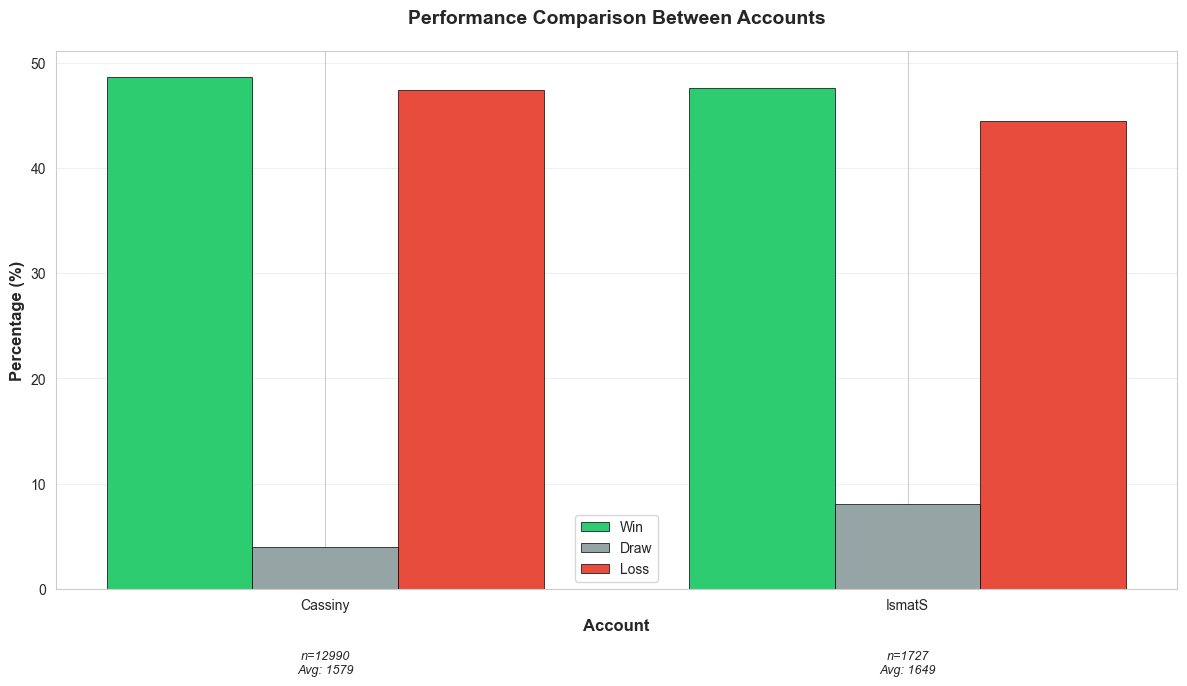

✓ Chart 14 saved: Account Comparison


In [19]:
# Chart 14: Account Comparison
fig, ax = plt.subplots(figsize=(12, 7))

account_stats = df.groupby('my_account')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
account_stats = account_stats[['win', 'draw', 'loss']]

x = np.arange(len(account_stats.index))
width = 0.25

ax.bar(x - width, account_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, account_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, account_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Account', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Performance Comparison Between Accounts', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(account_stats.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add game counts and average ratings
for i, account in enumerate(account_stats.index):
    account_data = df[df['my_account'] == account]
    games = len(account_data)
    avg_rating = account_data['my_elo'].mean()
    ax.text(i, -8, f'n={games}\nAvg: {avg_rating:.0f}', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('charts/14_account_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 14 saved: Account Comparison")

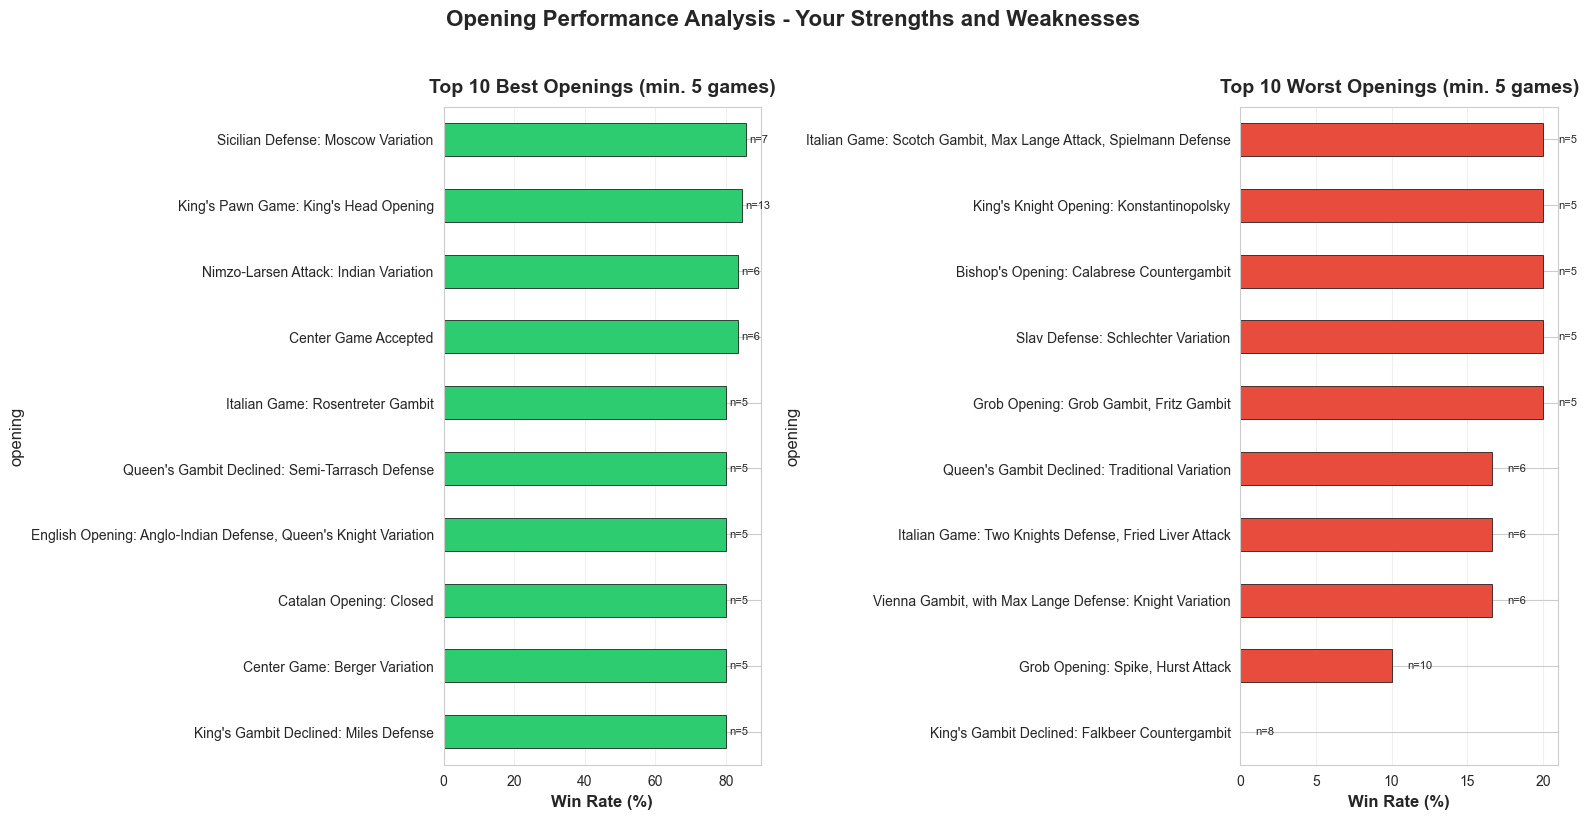

✓ Chart 15 saved: Best and Worst Openings


In [20]:
# Chart 15: Best and Worst Openings (Min 5 games)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Filter openings with at least 5 games
opening_counts = df['opening'].value_counts()
qualified_openings = opening_counts[opening_counts >= 5].index
df_qualified = df[df['opening'].isin(qualified_openings)]

# Calculate win rates
opening_win_rates = df_qualified.groupby('opening').apply(
    lambda x: (x['result'] == 'win').sum() / len(x) * 100
).sort_values()

# Top 10 best openings
best_openings = opening_win_rates.tail(10)
best_counts = df_qualified[df_qualified['opening'].isin(best_openings.index)]['opening'].value_counts()

best_openings.plot(kind='barh', ax=ax1, color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Win Rate (%)', fontweight='bold')
ax1.set_title('Top 10 Best Openings (min. 5 games)', fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3)

# Add counts
for i, opening in enumerate(best_openings.index):
    ax1.text(best_openings[opening] + 1, i, f'n={best_counts[opening]}', va='center', fontsize=8)

# Top 10 worst openings
worst_openings = opening_win_rates.head(10)
worst_counts = df_qualified[df_qualified['opening'].isin(worst_openings.index)]['opening'].value_counts()

worst_openings.plot(kind='barh', ax=ax2, color=COLORS['loss'], edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Win Rate (%)', fontweight='bold')
ax2.set_title('Top 10 Worst Openings (min. 5 games)', fontweight='bold', pad=10)
ax2.grid(axis='x', alpha=0.3)

# Add counts
for i, opening in enumerate(worst_openings.index):
    ax2.text(worst_openings[opening] + 1, i, f'n={worst_counts[opening]}', va='center', fontsize=8)

plt.suptitle('Opening Performance Analysis - Your Strengths and Weaknesses', 
             fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('charts/15_best_worst_openings.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 15 saved: Best and Worst Openings")

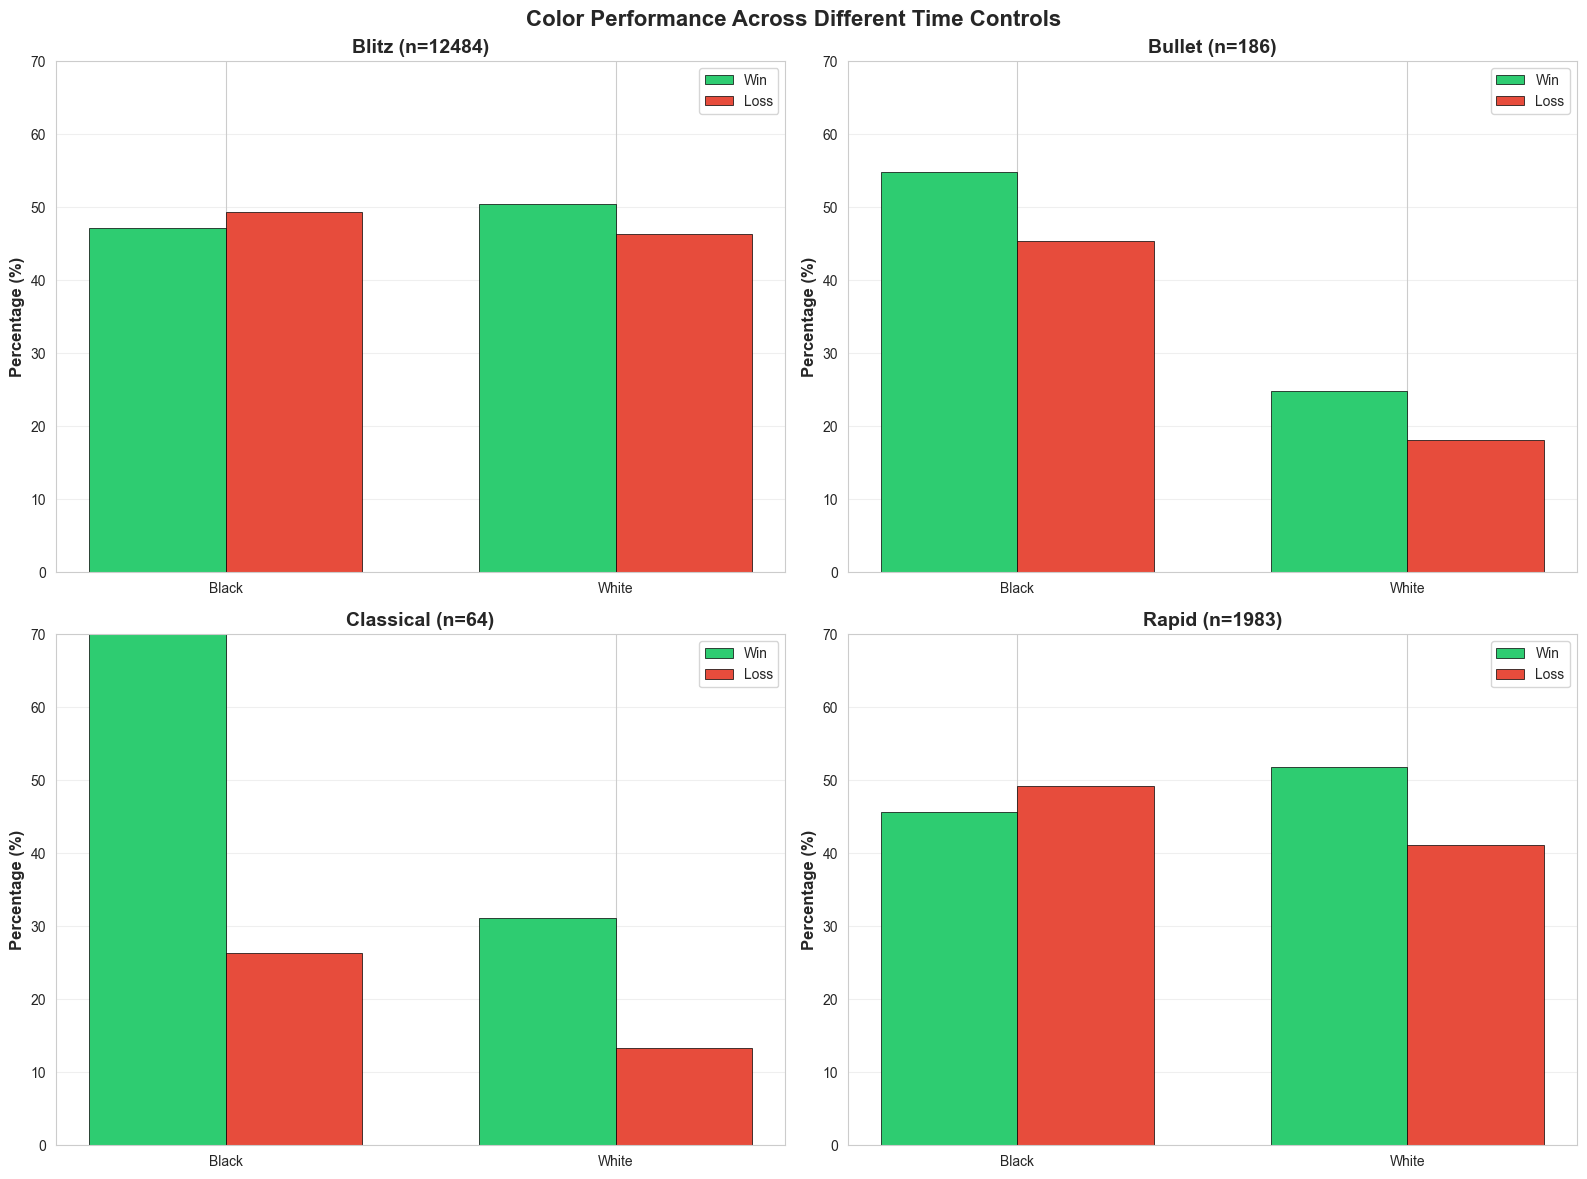

✓ Chart 16 saved: Color Performance by Time Control


In [21]:
# Chart 16: Color Performance by Time Control
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

time_controls = df['tc_category'].unique()

for idx, tc in enumerate(sorted(time_controls)):
    if idx >= 4:
        break
    
    ax = axes[idx]
    tc_data = df[df['tc_category'] == tc]
    
    color_perf = tc_data.groupby('my_color')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
    color_perf = color_perf[['win', 'loss']]
    
    x = np.arange(len(color_perf.index))
    width = 0.35
    
    ax.bar(x - width/2, color_perf['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
    ax.bar(x + width/2, color_perf['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'{tc} (n={len(tc_data)})', fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Black', 'White'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 70)

# Hide unused subplots
for idx in range(len(time_controls), 4):
    axes[idx].axis('off')

plt.suptitle('Color Performance Across Different Time Controls', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig('charts/16_color_performance_by_tc.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 16 saved: Color Performance by Time Control")

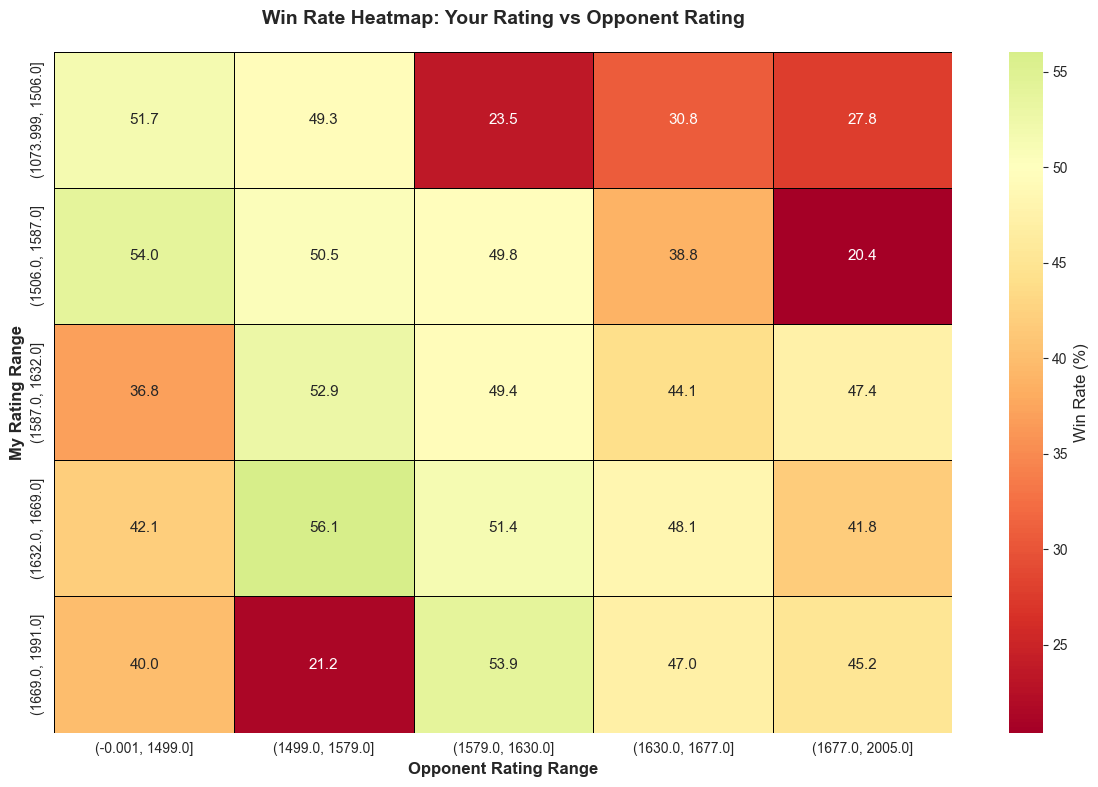

✓ Chart 17 saved: Opponent Rating Heatmap


In [22]:
# Chart 17: Opponent Rating Heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Create bins for my rating and opponent rating
my_rating_bins = pd.qcut(df['my_elo'], q=5, duplicates='drop')
opp_rating_bins = pd.qcut(df['opponent_elo'], q=5, duplicates='drop')

# Create pivot table for win rate
df_temp = df.copy()
df_temp['my_rating_bin'] = my_rating_bins
df_temp['opp_rating_bin'] = opp_rating_bins
df_temp['is_win'] = (df_temp['result'] == 'win').astype(int)

heatmap_data = df_temp.pivot_table(
    values='is_win', 
    index='my_rating_bin', 
    columns='opp_rating_bin', 
    aggfunc='mean'
) * 100

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=50, 
            cbar_kws={'label': 'Win Rate (%)'}, ax=ax, linewidths=0.5, linecolor='black')

ax.set_xlabel('Opponent Rating Range', fontweight='bold')
ax.set_ylabel('My Rating Range', fontweight='bold')
ax.set_title('Win Rate Heatmap: Your Rating vs Opponent Rating', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('charts/17_rating_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 17 saved: Opponent Rating Heatmap")

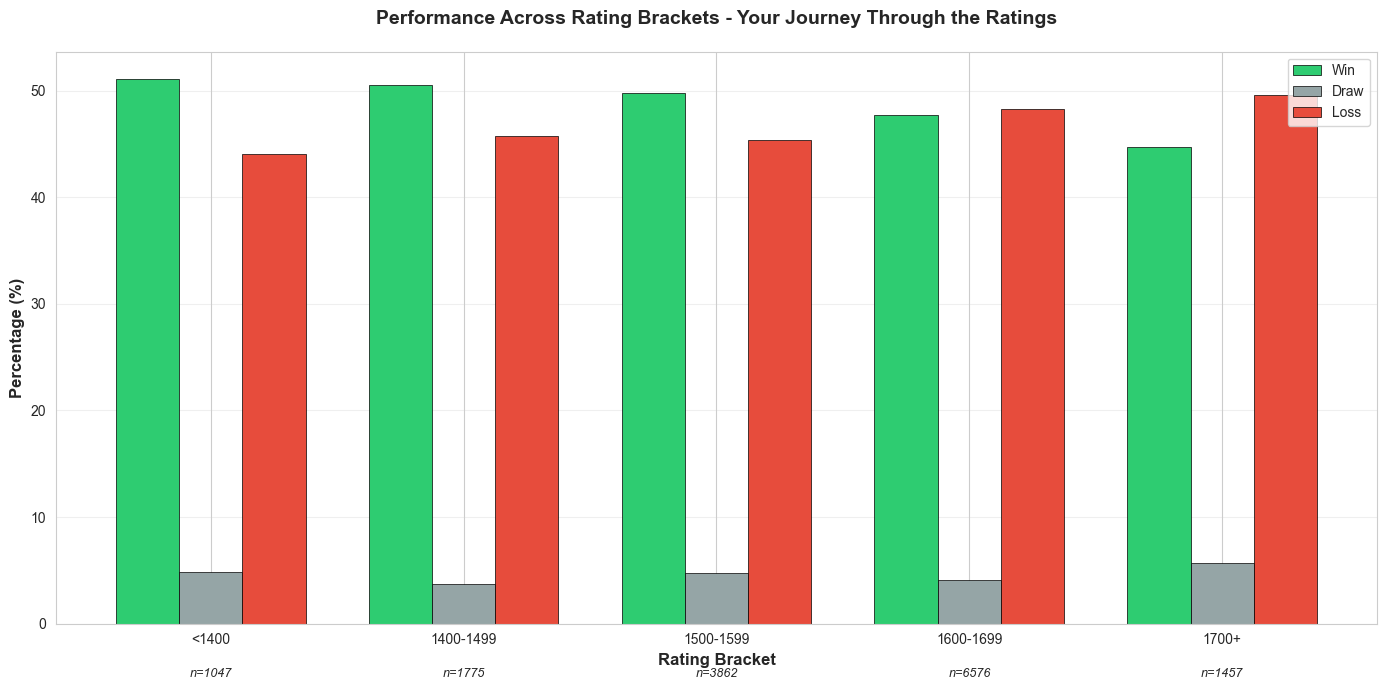

✓ Chart 18 saved: Win Rate by Rating Bracket


In [23]:
# Chart 18: Win Rate by Rating Bracket
fig, ax = plt.subplots(figsize=(14, 7))

# Create rating brackets
bins = [0, 1400, 1500, 1600, 1700, 3000]
labels = ['<1400', '1400-1499', '1500-1599', '1600-1699', '1700+']
df['my_rating_bracket'] = pd.cut(df['my_elo'], bins=bins, labels=labels)

bracket_stats = df.groupby('my_rating_bracket')['result'].value_counts(normalize=True).unstack(fill_value=0) * 100
bracket_stats = bracket_stats[['win', 'draw', 'loss']]

x = np.arange(len(bracket_stats.index))
width = 0.25

ax.bar(x - width, bracket_stats['win'], width, label='Win', color=COLORS['win'], edgecolor='black', linewidth=0.5)
ax.bar(x, bracket_stats['draw'], width, label='Draw', color=COLORS['draw'], edgecolor='black', linewidth=0.5)
ax.bar(x + width, bracket_stats['loss'], width, label='Loss', color=COLORS['loss'], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Rating Bracket', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_title('Performance Across Rating Brackets - Your Journey Through the Ratings', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add game counts
bracket_counts = df['my_rating_bracket'].value_counts().sort_index()
for i, (bracket, count) in enumerate(bracket_counts.items()):
    ax.text(i, -5, f'n={count}', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('charts/18_performance_by_rating_bracket.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 18 saved: Win Rate by Rating Bracket")

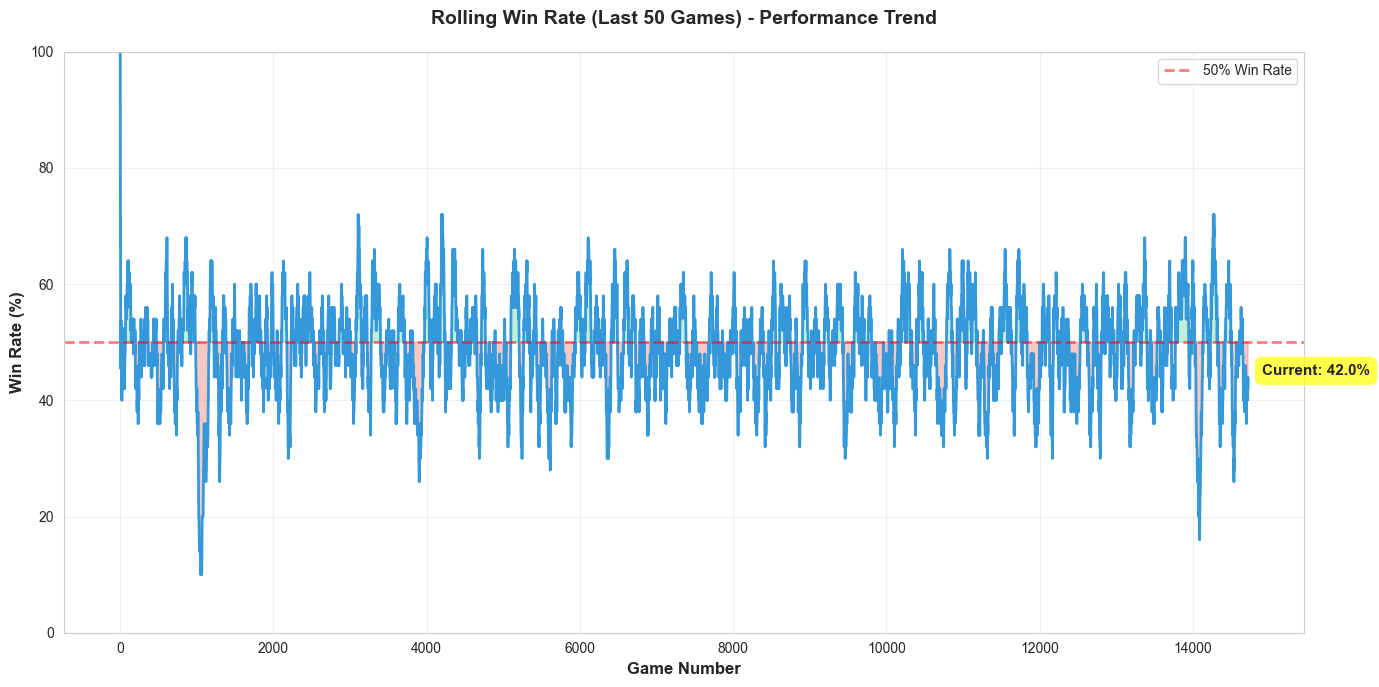

✓ Chart 19 saved: Rolling Win Rate


In [24]:
# Chart 19: Rolling Win Rate (Last 50 games)
fig, ax = plt.subplots(figsize=(14, 7))

df_sorted = df.sort_values('date').reset_index(drop=True)
df_sorted['is_win'] = (df_sorted['result'] == 'win').astype(int)

# Calculate rolling win rate
window = 50
df_sorted['rolling_win_rate'] = df_sorted['is_win'].rolling(window=window, min_periods=1).mean() * 100
df_sorted['game_number'] = range(1, len(df_sorted) + 1)

ax.plot(df_sorted['game_number'], df_sorted['rolling_win_rate'], linewidth=2, color=COLORS['primary'])
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% Win Rate')
ax.fill_between(df_sorted['game_number'], df_sorted['rolling_win_rate'], 50,
                where=(df_sorted['rolling_win_rate'] >= 50), alpha=0.3, color=COLORS['win'])
ax.fill_between(df_sorted['game_number'], df_sorted['rolling_win_rate'], 50,
                where=(df_sorted['rolling_win_rate'] < 50), alpha=0.3, color=COLORS['loss'])

ax.set_xlabel('Game Number', fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontweight='bold')
ax.set_title(f'Rolling Win Rate (Last {window} Games) - Performance Trend', fontweight='bold', pad=20)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

# Add current win rate
current_wr = df_sorted['rolling_win_rate'].iloc[-1]
ax.annotate(f'Current: {current_wr:.1f}%',
            xy=(len(df_sorted), current_wr),
            xytext=(10, 10), textcoords='offset points',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('charts/19_rolling_win_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 19 saved: Rolling Win Rate")

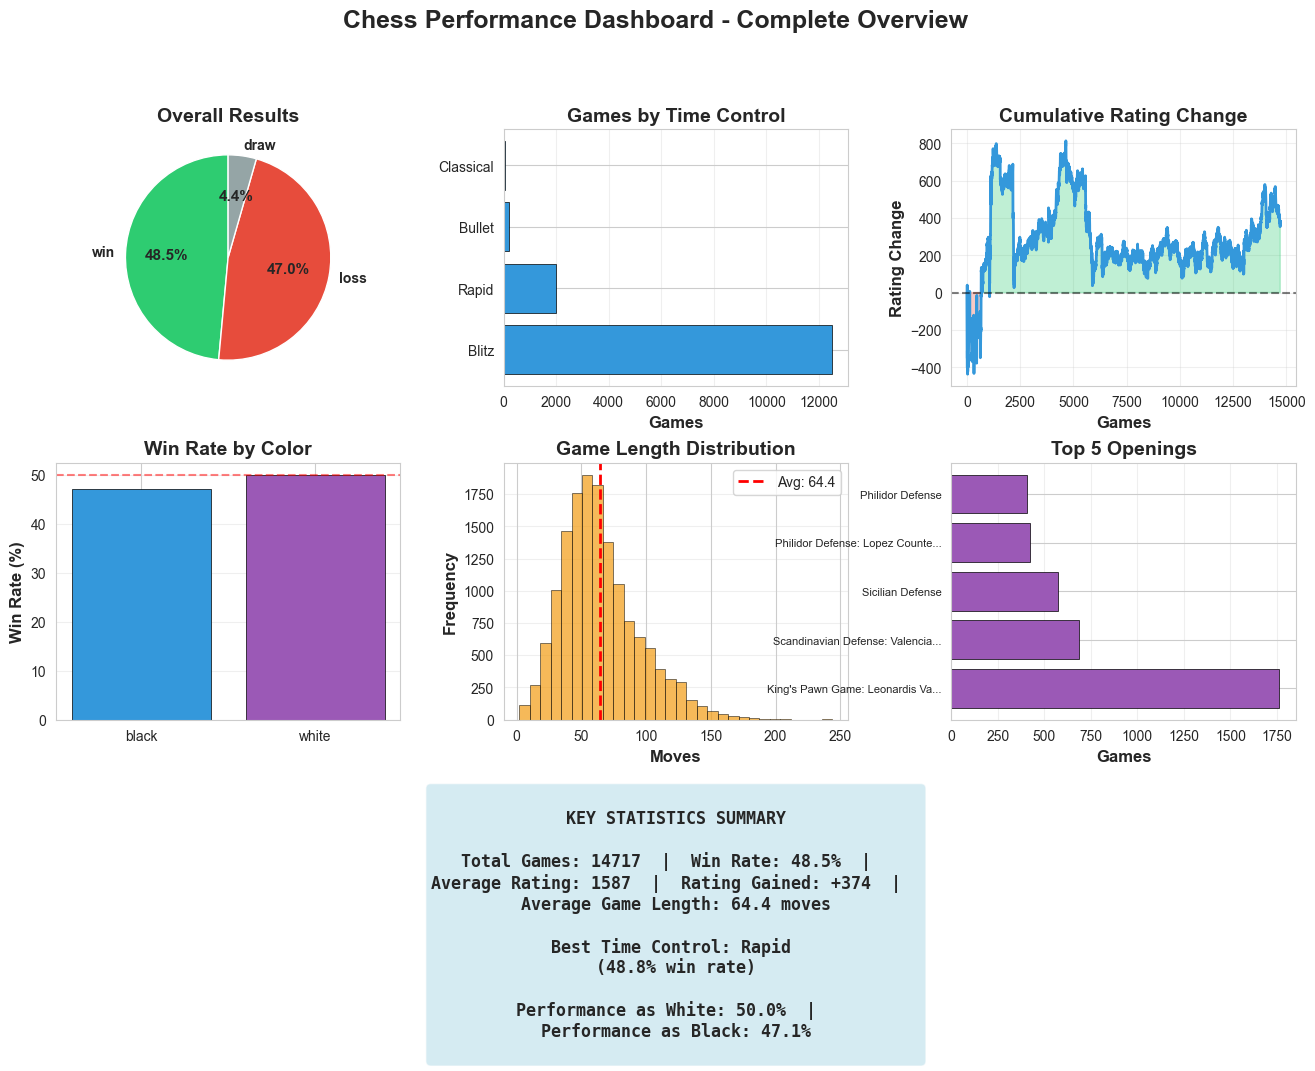

✓ Chart 20 saved: Comprehensive Performance Dashboard


In [25]:
# Chart 20: Comprehensive Performance Summary Dashboard
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Overall Win Rate
ax1 = fig.add_subplot(gs[0, 0])
results = df['result'].value_counts()
colors = [COLORS['win'], COLORS['loss'], COLORS['draw']]
wedges, texts, autotexts = ax1.pie(results, labels=results.index, autopct='%1.1f%%', 
                                     colors=colors, startangle=90, textprops={'fontweight': 'bold'})
ax1.set_title('Overall Results', fontweight='bold')

# Games per Time Control
ax2 = fig.add_subplot(gs[0, 1])
tc_counts = df['tc_category'].value_counts()
ax2.barh(range(len(tc_counts)), tc_counts.values, color=COLORS['primary'], edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(tc_counts)))
ax2.set_yticklabels(tc_counts.index)
ax2.set_xlabel('Games', fontweight='bold')
ax2.set_title('Games by Time Control', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Rating Progress
ax3 = fig.add_subplot(gs[0, 2])
df_sorted = df.sort_values('date').reset_index(drop=True)
df_sorted['cumulative'] = df_sorted['my_rating_change'].cumsum()
ax3.plot(df_sorted['cumulative'], linewidth=2, color=COLORS['primary'])
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.fill_between(range(len(df_sorted)), df_sorted['cumulative'], 0, 
                where=(df_sorted['cumulative'] >= 0), alpha=0.3, color=COLORS['win'])
ax3.fill_between(range(len(df_sorted)), df_sorted['cumulative'], 0,
                where=(df_sorted['cumulative'] < 0), alpha=0.3, color=COLORS['loss'])
ax3.set_xlabel('Games', fontweight='bold')
ax3.set_ylabel('Rating Change', fontweight='bold')
ax3.set_title('Cumulative Rating Change', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Color Performance
ax4 = fig.add_subplot(gs[1, 0])
color_wr = df.groupby('my_color')['result'].apply(lambda x: (x == 'win').sum() / len(x) * 100)
ax4.bar(range(len(color_wr)), color_wr.values, color=[COLORS['primary'], COLORS['secondary']], 
        edgecolor='black', linewidth=0.5)
ax4.set_xticks(range(len(color_wr)))
ax4.set_xticklabels(color_wr.index)
ax4.set_ylabel('Win Rate (%)', fontweight='bold')
ax4.set_title('Win Rate by Color', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=50, color='red', linestyle='--', alpha=0.5)

# Game Length
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(df['total_moves'], bins=30, color=COLORS['accent'], edgecolor='black', linewidth=0.5, alpha=0.7)
ax5.axvline(x=df['total_moves'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f"Avg: {df['total_moves'].mean():.1f}")
ax5.set_xlabel('Moves', fontweight='bold')
ax5.set_ylabel('Frequency', fontweight='bold')
ax5.set_title('Game Length Distribution', fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Top 5 Openings
ax6 = fig.add_subplot(gs[1, 2])
top5_openings = df['opening'].value_counts().head(5)
y_pos = range(len(top5_openings))
ax6.barh(y_pos, top5_openings.values, color=COLORS['secondary'], edgecolor='black', linewidth=0.5)
ax6.set_yticks(y_pos)
ax6.set_yticklabels([op[:30] + '...' if len(op) > 30 else op for op in top5_openings.index], fontsize=8)
ax6.set_xlabel('Games', fontweight='bold')
ax6.set_title('Top 5 Openings', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

# Key Statistics Text
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

stats_text = f"""
KEY STATISTICS SUMMARY

Total Games: {len(df)}  |  Win Rate: {(df['result']=='win').sum()/len(df)*100:.1f}%  |  
Average Rating: {df['my_elo'].mean():.0f}  |  Rating Gained: {df['my_rating_change'].sum():+d}  |  
Average Game Length: {df['total_moves'].mean():.1f} moves

Best Time Control: {df.groupby('tc_category')['result'].apply(lambda x: (x=='win').sum()/len(x)*100).idxmax()} 
({df.groupby('tc_category')['result'].apply(lambda x: (x=='win').sum()/len(x)*100).max():.1f}% win rate)

Performance as White: {(df[df['my_color']=='white']['result']=='win').sum()/len(df[df['my_color']=='white'])*100:.1f}%  |  
Performance as Black: {(df[df['my_color']=='black']['result']=='win').sum()/len(df[df['my_color']=='black'])*100:.1f}%
"""

ax7.text(0.5, 0.5, stats_text, ha='center', va='center', fontsize=12, 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
        family='monospace', fontweight='bold')

plt.suptitle('Chess Performance Dashboard - Complete Overview', fontweight='bold', fontsize=18)
plt.savefig('charts/20_performance_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart 20 saved: Comprehensive Performance Dashboard")

In [26]:
print("\n" + "="*80)
print("ALL CHARTS GENERATED SUCCESSFULLY!")
print("="*80)
print("\nTotal charts created: 20")
print("All charts saved to: /charts directory")
print("\nYou can now create a README.md file with these charts embedded!")


ALL CHARTS GENERATED SUCCESSFULLY!

Total charts created: 20
All charts saved to: /charts directory

You can now create a README.md file with these charts embedded!
